# Implmementing a Simple Research Assistant Agent

1. Setup env
2. Setup tools/model/bind model to tools
3. Setup assistant as a simple function that invokes the model + tools
4. Initialize the state
5. Setup graph with nodes and edges
6. Compile + invoke

In [1]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"var: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

In [3]:
# setup the tools
from langchain_community.tools import TavilySearchResults

search_tool = TavilySearchResults(max_results=5)

search_tool.invoke({"query": "What is langgraph?"})

[{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': 'LangGraph is a library within the LangChain ecosystem designed to tackle these challenges head-on. LangGraph provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured manner.'},
 {'url': 'https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787',
  'content': "LangGraph is a low-level framework that offers extensive customisation options, allowing you to build precisely what you need. Since LangGraph is built on top of LangChain, it's seamlessly integrated into its ecosystem, making it easy to leverage existing tools and components. However, there are areas where LangGrpah could be improved:"},
 {'url': 'https://langchain-ai.github.io/langgraph/',
  'content': 'Overview¶. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other LLM fram

In [6]:
# setup model + bind to tools
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

tools = [search_tool]
llm_with_tools = llm.bind_tools(tools)
llm_with_tools.invoke("What is langgraph?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lgxsNqJnXmoFzCXvV2q641CJ', 'function': {'arguments': '{"query":"langgraph"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 84, 'total_tokens': 103, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9a8b0a8c-565b-4b0a-adb9-8eafa4a94246-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'langgraph'}, 'id': 'call_lgxsNqJnXmoFzCXvV2q641CJ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 84, 'output_tokens': 19, 'total_tokens': 103, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_tok

In [8]:
# payload prepared by the LLM for calling the search tool
output = llm_with_tools.invoke("What is langgraph?")

output.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'langgraph'},
  'id': 'call_RpCpq0VfxWCZCo4HgT1WWAee',
  'type': 'tool_call'}]

In [15]:
from langgraph.graph import MessagesState

class ResearchAssistantState(MessagesState):
    pass

In [16]:
def assistant(state: ResearchAssistantState):
    sys_msg = "You are a helpful assistant that can search \
        the web for information and return an organized mini report containing the answer with references used."
    return {"messages":llm_with_tools.invoke([sys_msg] + state["messages"])}

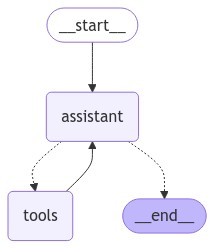

In [21]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image

builder = StateGraph(ResearchAssistantState)

# Nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Edges 
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

Image(graph.get_graph().draw_mermaid_png())

In [23]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}

output = graph.invoke({"messages": [
    HumanMessage(content="Look up live-training courses by Lucas Soares at O'Reilly Media.")]}, config=config)

for m in output["messages"]:
    m.pretty_print()

================================ Human Message =================================

Look up live-training courses by Lucas Soares at O'Reilly Media.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_zamDN6iv5GxxSAIvgdDTvoKO)
 Call ID: call_zamDN6iv5GxxSAIvgdDTvoKO
  Args:
    query: live-training courses Lucas Soares site:oreilly.com
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.oreilly.com/products/new-live-online-sessions.html", "content": "live online training. November 21, 2024. ... Crash Course. Presented by Chad Smith. Publisher(s): Pearson. live online training. December 16, 2024. Microsoft Copilot for Security Quick Start. Presented by Joseph Muniz, Erik Snyder. ... Presented by Lucas Soares. Publisher(s): O'Reilly Media, Inc. live online training."}, {"url": "https://www.oreilly.com/live-events/getting-started-wi

In [24]:
message = HumanMessage(content="What did I ask you about?")

output = graph.invoke({"messages": [message]}, config=config)

for m in output["messages"]:
    m.pretty_print()

================================ Human Message =================================

Look up live-training courses by Lucas Soares at O'Reilly Media.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_zamDN6iv5GxxSAIvgdDTvoKO)
 Call ID: call_zamDN6iv5GxxSAIvgdDTvoKO
  Args:
    query: live-training courses Lucas Soares site:oreilly.com
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.oreilly.com/products/new-live-online-sessions.html", "content": "live online training. November 21, 2024. ... Crash Course. Presented by Chad Smith. Publisher(s): Pearson. live online training. December 16, 2024. Microsoft Copilot for Security Quick Start. Presented by Joseph Muniz, Erik Snyder. ... Presented by Lucas Soares. Publisher(s): O'Reilly Media, Inc. live online training."}, {"url": "https://www.oreilly.com/live-events/getting-started-wi